Import the necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum
import math

Section 1.0: Setup

In [76]:
class BasisFunctions(Enum):
    LINEAR = "linear"
    POLYNOMIAL = "polynomial"
    GAUSSIAN = "gaussian"
    SIGMOID = "sigmoid"

class GDMethods(Enum):
    GD = "gd"
    SGD = "sgd"
    ANALYTIC = "analytic"

class Linear_Regression:
    """
    Initializes Linear Regression model with configurable basis functions. Assumes 0 initial weights. Note that
    self.weights.shape = (num_features + 1,) due to bias being always linear.

    Args:
        X (numpy.ndarray): list of base, linear features (Nx1)
        y (numpy.ndarray): Targets (Nx1)
        basis_function (BasisFunctions): basis function that gets applied to each feature.
        num_features (int): number of features (if 0, will only have bias)
    """
    def __init__(self, X, y, num_features, basis_function: BasisFunctions):
        self.basis_function = basis_function
        self.num_features = num_features
        self.weights = np.zeros(self.num_features + 1)
        self.X = self.transform_X(X)
        self.y = y
    
    """
    Will transform the X design matrix into a transformed design matrix (capital Phi) by applying the corresponding basis function.
    Returns an N x (num_features + 1) design matrix where the (num_features) rightmost columns have the basis function applied.
    """
    def transform_X(self, X):
        X = X.reshape(-1, 1)
        N = X.shape[0]

        temp = np.ones((N, 1)).reshape(-1, 1)
        match self.basis_function:
            case BasisFunctions.LINEAR: 
                for i in range (1, self.num_features + 1):
                    temp = np.hstack((temp, X))
            case BasisFunctions.POLYNOMIAL:
                for i in range (1, self.num_features + 1):
                    temp = np.hstack((temp, X ** i))
            case BasisFunctions.GAUSSIAN:
                X_max = np.max(X)
                X_min = np.min(X)
                for i in range (1, self.num_features + 1):
                    mean = X_min + (X_max - X_min) * (i - 1) / (self.num_features - 1)
                    exponent = -((X - mean)**2)
                    gaussian = np.exp(exponent)
                    temp = np.hstack((temp, gaussian))
            case BasisFunctions.SIGMOID:
                X_max = np.max(X)
                X_min = np.min(X)
                for i in range (1, self.num_features + 1):
                    mean = X_min + (X_max - X_min) * (i - 1) / (self.num_features - 1)
                    exponent = -(X - mean)
                    sigmoid = 1 / (1 + np.exp(exponent))
                    temp = np.hstack((temp, sigmoid))
        return temp    

    def reset_model(self):
        self.weights = np.zeros(self.num_features + 1)
    
    def plot_bases(self):
        pass

    def plot_model(self, X_data, y_data, show_bases=True, show_true_function=False, **kwargs):
        w = np.asarray(self.weights).reshape(-1)

        x_dense = np.linspace(X_data.min(), X_data.max(), 1000)

        Phi_dense = self.transform_X(x_dense)
        y_hat = Phi_dense @ w

        plt.figure(figsize=(8, 4.5))
        plt.scatter(X_data, y_data, s=18, alpha=0.75, label="data", color="blue")

        if show_bases:
            # Plot each weighted basis (skip bias column 0)
            for j in range(1, Phi_dense.shape[1]):
                plt.plot(x_dense, w[j] * Phi_dense[:, j], linewidth=0.8, alpha=0.4)

        if show_true_function and kwargs.get("true_function"):
            true_function = kwargs.get("true_function")
            plt.plot(x_dense, true_function(x_dense), alpha=0.75, label="true function", color="green")

        plt.plot(x_dense, y_hat, linewidth=2.5, label="model", color="red")
        plt.ylim(bottom=np.min(self.y) - 0.5, top=np.max(self.y) + 0.5)
        plt.title(kwargs.get("title") if not None else f"Linear Regression with {self.basis_function.value.capitalize()} bases")
        plt.legend()
        plt.tight_layout()
        plt.show()

    """
    Fits the linear regression model depending on GD method. Different arguments are required depending on method.
    kwargs contains: "epoch", "learning_rate"
    """
    def fit(self, method: GDMethods, **kwargs):
        match method:
            case GDMethods.ANALYTIC:
                self.weights = np.linalg.pinv(self.X.T @ self.X) @ self.X.T @ self.y
            case GDMethods.SGD:
                lr = float(kwargs.get("learning_rate"))
                for epoch in range(1, int(kwargs.get("epoch")) + 1):
                    epoch_loss = np.sum((self.X @ self.weights - self.y)**2) / self.X.shape[0]
                    print(f"Epoch {epoch - 1} SSE: {epoch_loss}")
                    for (x, y) in zip(self.X, self.y):
                        grad = x * (self.weights.T @ x - y)
                        self.weights -= lr * grad / grad.shape[0]
                
                final_loss = np.sum((self.X @ self.weights - self.y)**2) / self.X.shape[0]
                print(f"Final SSE: {final_loss}")
            case GDMethods.GD:
                lr = float(kwargs.get("learning_rate"))
                for epoch in range(1, int(kwargs.get("epoch")) + 1):
                    epoch_loss = np.sum((self.X @ self.weights - self.y)**2) / self.X.shape[0]
                    print(f"Epoch {epoch - 1} SSE: {epoch_loss}")
                    
                    grad = self.X.T @ (self.X @ self.weights - self.y) / self.X.shape[0]
                    self.weights -= lr * grad
                
                final_loss = np.sum((self.X @ self.weights - self.y)**2) / self.X.shape[0]
                print(f"Final SSE: {final_loss}")


    """
    Samples one value from a given function while adding Gaussian noise.

    Args:
        x (float): Input to function
        function (Callable(float, float)): Function to be sampled from.
        std (float): Standard deviation
        seed (int): Defaulted to None, but used for consistent sampling
    
    Returns:
        float: Sampled value from function
    """
    @staticmethod
    def gaussian_noise_sampling(x, function, std=1, seed=None):
        gaussian_sample = np.random.default_rng(seed=seed).normal(loc=0, scale=std, size=1)
        return function(x) + gaussian_sample

    @staticmethod
    def sampler(function, sample_size, x_start, x_end, std=1, seed=None, random=False):
        if random:
            x_values = np.random.default_rng().uniform(low=x_start, high=x_end, size=sample_size)
            # x_values = np.sort(x_values)
        else:
            x_values = np.linspace(x_start, x_end, sample_size)
        
        y_values = []
        for i in range(sample_size):
            y_values.append(Linear_Regression.gaussian_noise_sampling(x_values[i], function, std, seed)[0])
        
        y_values = np.array(y_values)

        return {"x": x_values, "y": y_values}
    
    @staticmethod
    def assignment_function(x):
        return (np.log(x) + 1) * np.cos(x) + np.sin(2 * x)

    @staticmethod
    def random_test_function(x):
        return x * np.cos(x) + x * x
    
    # Will use an 80/20 split to train/validate.
    @staticmethod
    def cross_validation_10_fold(X, y):
        X = X
        y = y
        N = X.shape[0]

        X_train = X[:0.8 * N]
        y_train = y[:0.8 * N]

        X_folds = np.array_split(X_train, 10)
        y_folds = np.array_split(y_train, 10)

        X_test = X[0.8*N:]
        y_test = y[0.8 * N:]

        # { val: float, std: float}
        results = {}

        # 10 diff hyperparam (#features) values (0, 5, ..., 40, 45)
        for i in range(10):
            
            # the actual 10-fold CV
            temp_err = []
            for j in range(10):
                training_X = np.vstack([X_folds[k] for k in range(10) if k != j])
                training_y = np.hstack([y_folds[k] for k in range(10) if k != j])
                validating_X = X_folds[j]
                validating_y = y_folds[j]

                model = Linear_Regression(training_X, training_y, num_features=i*5, basis_function=BasisFunctions.GAUSSIAN)
                model.fit(GDMethods.ANALYTIC)
                temp_err.append(np.sum((validating_X @ model.weights - validating_y)**2) / validating_X.shape[0])
            results[i * 5] = { "val_err": np.mean(temp_err), "std": np.std(temp_err) }
        
        return results




Section 1.1: Mock data

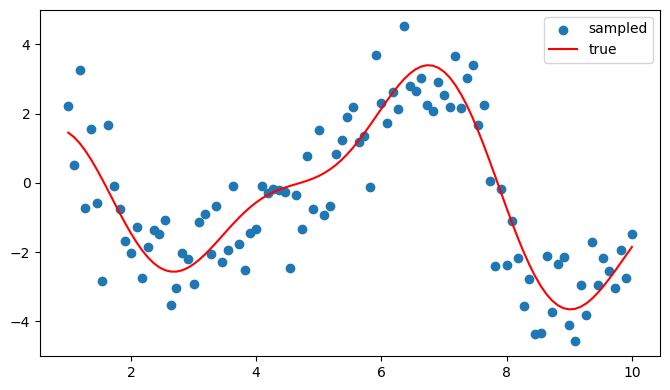

In [74]:
data = Linear_Regression.sampler(Linear_Regression.assignment_function, 100, 1, 10, random=False)
x = data.get("x")
y = data.get("y")

plt.figure(figsize=(8, 4.5))
plt.scatter(x, y, label="sampled")
plt.plot(x, Linear_Regression.assignment_function(x), label="true", color='red')
plt.legend()
plt.show()

Section 1.2/1.3: Fitting with various amounts of basis functions

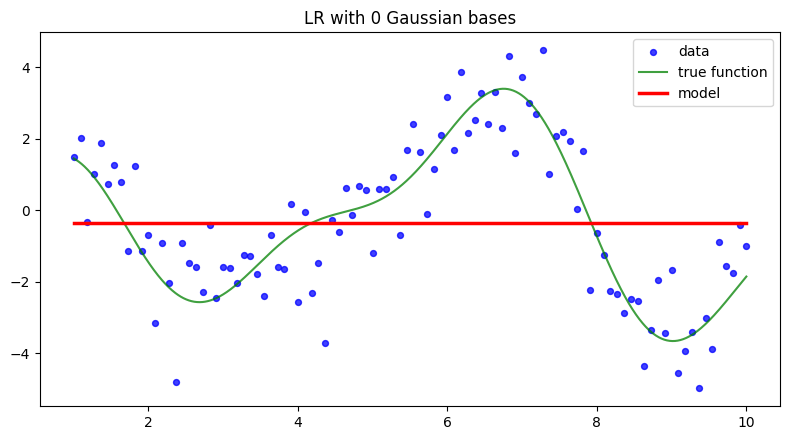

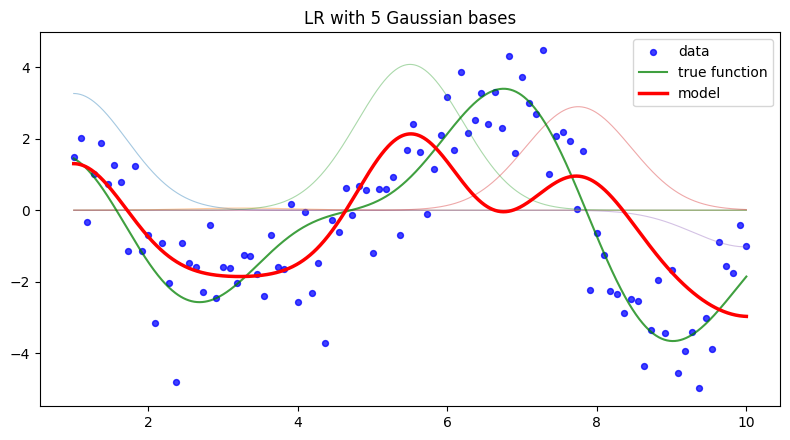

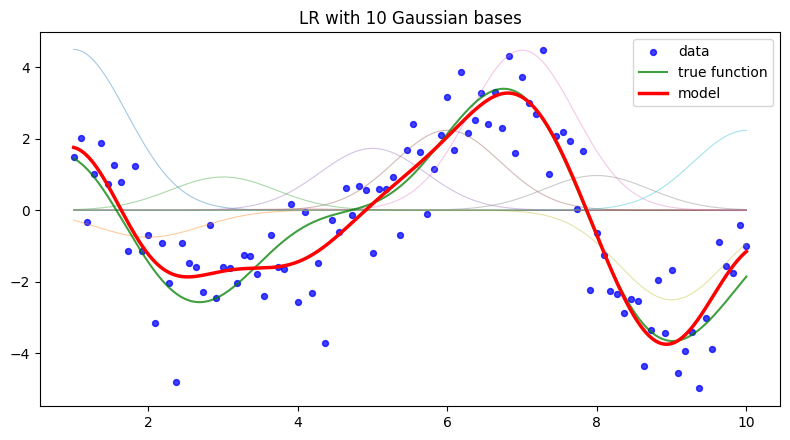

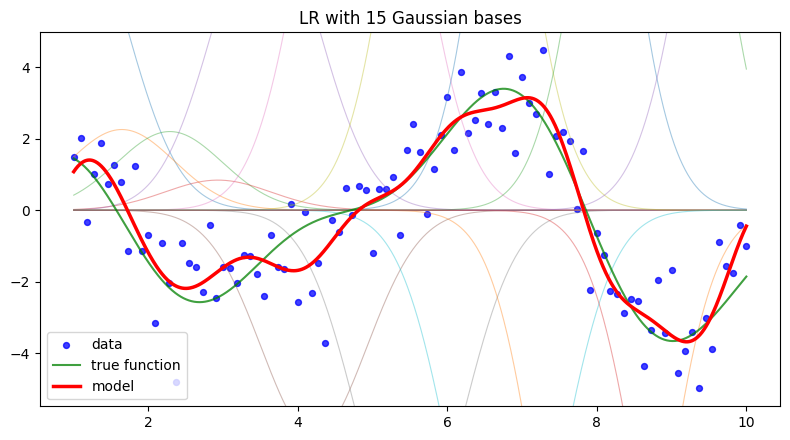

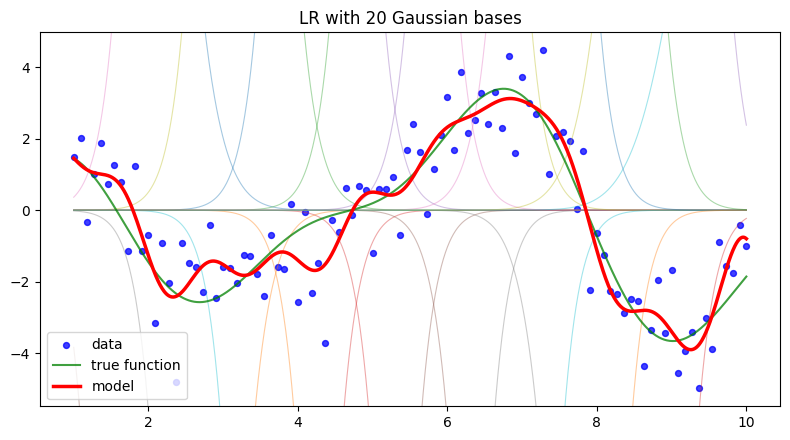

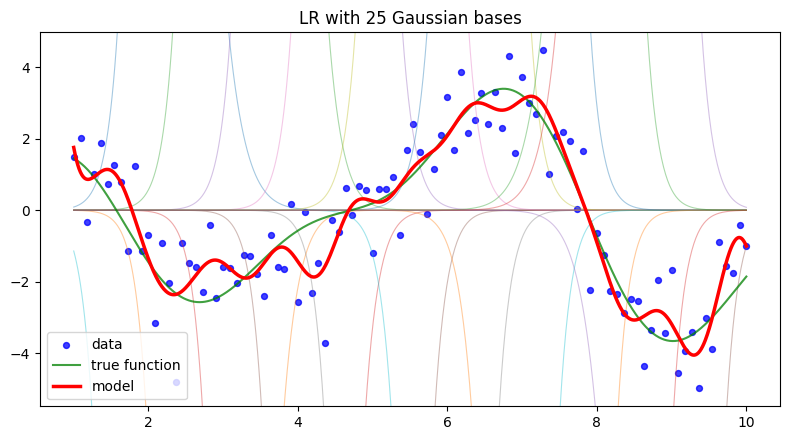

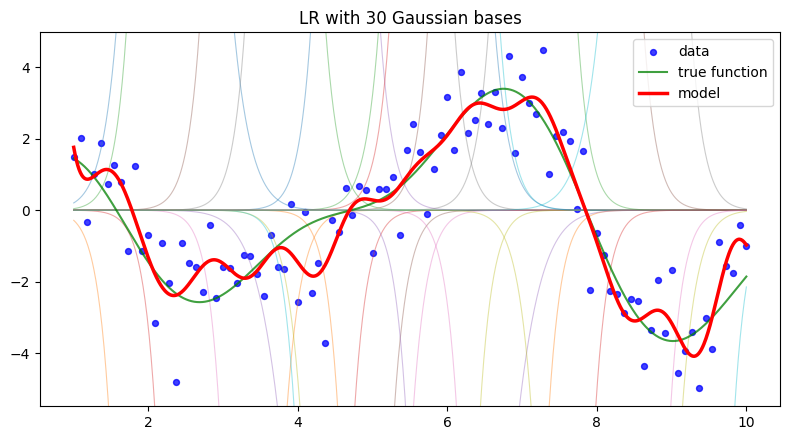

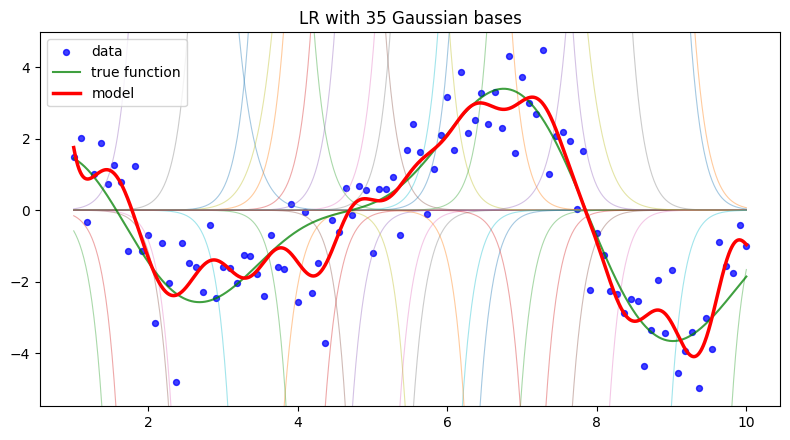

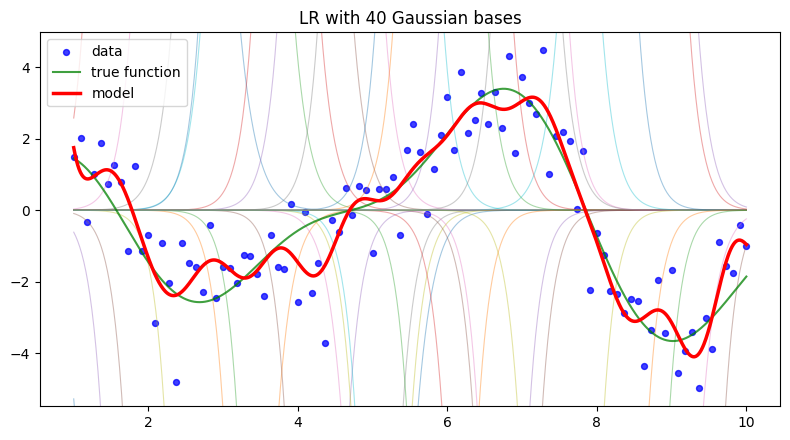

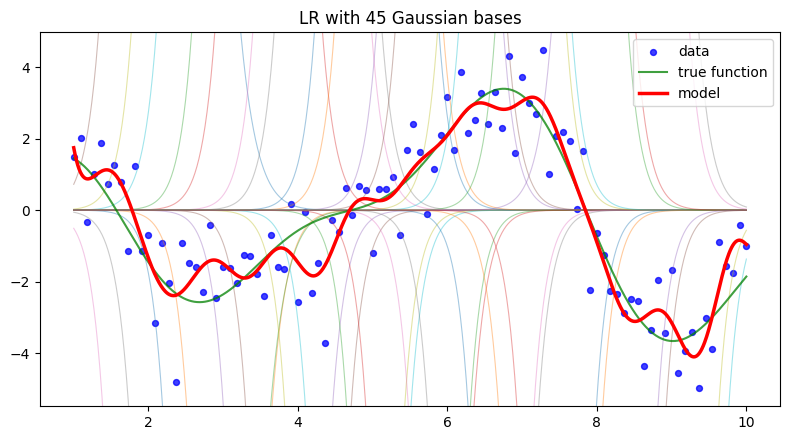

In [68]:
for i in range(10):
    model = Linear_Regression(x, y, num_features=i*5, basis_function=BasisFunctions.GAUSSIAN)
    model.fit(GDMethods.ANALYTIC)
    model.plot_model(x, y, show_bases=True, show_true_function=True, true_function=Linear_Regression.assignment_function, title=f"LR with {i*5} Gaussian bases")

Section 1.4: 10-fold Cross-Validation for #basis selection

In [77]:
results = Linear_Regression.cross_validation_10_fold(x, y)

TypeError: slice indices must be integers or None or have an __index__ method